In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from gensim.corpora import WikiCorpus, dictionary
import gensim.downloader as api
from compare_tools.configuration import wem_loader
from scipy import sparse
import numpy as np
import time
import glob
import os
import pandas as pd
from glove import Corpus, Glove
from htrc_features import utils
from motes_corpus.youtube import YTCaptionCorpus
from motes_corpus.subtitles import SubtitleCorpus
from motes_corpus.hathibook import HathiCorpus
from motes_corpus import modeling

Aligning with the GloVe wiki gigaword 300 model, which as 40000 *uncased* tokens, trained on 6B tokens from Wikipedia in 2014.

In [8]:
#model = wem_loader('glove-wiki-gigaword-300')

In [4]:
# Write vocab into a gensim dictionary format
dict_path = '/data/motes/gigaword_300_dict.txt'
if not os.path.exists(dict_path):
    with open(dict_path, mode='w') as f:
        f.write('1\n')
        for i, word in enumerate(model.vocab.keys()):
            f.write('{}\t{}\t1\n'.format(i, word))
model_dict = dictionary.Dictionary.load_from_text(dict_path)
n_words = len(model_dict)

data_path = '/data/motes/'
coocs_path = os.path.join(data_path, 'coocs')

## Training Cooccurrence Matrix

GloVe uses a weighting of $(w/w_{max})^\alpha$ for words that occur less than $w_{max}$. In Pennington et al 2014, they use $w_{max}=100$ and $\alpha=\frac{3}{4}$. This will be done later - for now we're just collecting raw cooccurrence counts.


- Good guide: http://www.foldl.me/2014/glove-python/

### Baseline English Wikipedia

This will be the foundation on which the children's corpus is built.

Since it is large, processing it in a notebook is unreasonable. Instead, see [train_enwiki.cooc.py](../training/train_enwiki.cooc.py)

It was processed in batches, 

```bash
python train_enwiki_cooc.py /data/motes/enwiki_cooc_full3_2_raw.npz -n 348268 -m 51732
python train_enwiki_cooc.py /data/motes/enwiki_cooc_full4_raw.npz -n 400000 -m 600000
...
python train_enwiki_cooc.py /data/motes/enwiki_cooc_full12_raw.npz -n 6500000
```

..then combined into one big matrix:

```python
import glob
paths = glob.glob('/data/motes/enwiki_cooc_full*') + ['/data/motes/coocs/enwiki_cooc_317k_raw.npz']
all_dists = []
validate = []
for i, path in enumerate(paths):
    partial_mat = sparse.load_npz(path)    
    validate.append((path, partial_mat.sum()))
    print(validate[-1])
    
    if i == 0:
        full_mat = partial_mat
    else:
        full_mat += partial_mat
sparse.save_npz('/data/motes/coocs/enwiki_full.npz', full_mat)
```

In [19]:
a = full_mat.sum() / sparse.load_npz(os.path.join(coocs_path, 'enwiki_cooc_317k_raw.npz')).sum()
print("The full en wikipedia is {}x as big as the 317k pages in the CHI paper".format(a))

The full en wikipedia is 5.152919302929286x as big as the 317k pages in the CHI paper


### Simple Wikipedia

In [522]:
wiki = WikiCorpus('/data/motes/simplewiki/simplewiki-latest-pages-articles.xml.bz2', lemmatize=False, dictionary=model_dict)

In [245]:
word_n = 0
docs = 0
for i, text in enumerate(wiki.get_texts()):
    word_n += len(text)
    docs += 1
    if i % 50000 == 0:
        print(i, end=', ')
print('\n', word_n, docs)

0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 15000, 15500, 16000, 16500, 17000, 17500, 18000, 18500, 19000, 19500, 20000, 20500, 21000, 21500, 22000, 22500, 23000, 23500, 24000, 24500, 25000, 25500, 26000, 26500, 27000, 27500, 28000, 28500, 29000, 29500, 30000, 30500, 31000, 31500, 32000, 32500, 33000, 33500, 34000, 34500, 35000, 35500, 36000, 36500, 37000, 37500, 38000, 38500, 39000, 39500, 40000, 40500, 41000, 41500, 42000, 42500, 43000, 43500, 44000, 44500, 45000, 45500, 46000, 46500, 47000, 47500, 48000, 48500, 49000, 49500, 50000, 50500, 51000, 51500, 52000, 52500, 53000, 53500, 54000, 54500, 55000, 55500, 56000, 56500, 57000, 57500, 58000, 58500, 59000, 59500, 60000, 60500, 61000, 61500, 62000, 62500, 63000, 63500, 64000, 64500, 65000, 65500, 66000, 66500, 67000, 67500, 68000, 68500, 69000, 69500, 70000, 70500, 71000, 71500, 72000, 72500, 73

In [ ]:
wikicooc = modeling.train_coocurrence_matrix(wiki.get_texts(), model_dict,
                                             window_size=10, print_every=2000)
sparse.save_npz('/data/motes/simplewiki_cooc_raw.npz', wikicooc)

### Youtube

Stats in CHI submission \#1:

```{'words': 9157014, 'docs': 15037, 'types': 265208}```

Given the slow pace of collection from YouTube, we've kept the crawler going.

Stats on Oct 9:

```{'words': 28853789, 'docs': 41014, 'types': 507183}``` (3.15x words)

In [11]:
for i in range(5):
    subset_of_paths = caption_paths[i::5]
    print(i, len(subset_of_paths), subset_of_paths[0])

0 8203 /data/motes/yt_captions/09-08/RYW5q6A1K24.json
1 8203 /data/motes/yt_captions/09-08/5rZSTn2S_iU.json
2 8203 /data/motes/yt_captions/09-08/JOdcsT6aD6A.json
3 8203 /data/motes/yt_captions/09-08/Cw6FLD_SnkM.json
4 8202 /data/motes/yt_captions/09-08/sTw-vEMLqWA.json


In [15]:
subset_of_paths = caption_paths[0::50]

def glove_from_paths(paths, run_name, truncate_to=100000):
    ytcorpus = YTCaptionCorpus(paths)
    # TODO - save information connecting paths to name
    cooc = modeling.train_coocurrence_matrix(ytcorpus.tokens(), model_dict,
                                             window_size=10, print_every=2000)
    # Truncate just to top n words in vocab
    m = cooc.tocsc()[:truncate_to, :truncate_to].tocoo()

    glove = Glove(no_components=300, learning_rate=0.05) 
    glove.fit(m, epochs=100, no_threads=25, verbose=True)
    del m # not necessary, mainly for testing
    dictionary = dict(list(model_dict.token2id.items())[:n])
    glove.add_dictionary(dictionary)

    # Convert to keyed vectors and save
    kv = modeling.glove_to_keyedvectors(glove)
    kv.save('/data/motes/models/{}.kv'.format(run_name))
    
glove_from_paths(subset_of_paths, 'r1_split1')

Docs processed: 0	 time: 0s	 docs/second: 0
Final docs processed: 820	 time: 11s	 docs/second: 70


<400000x400000 sparse matrix of type '<class 'numpy.float64'>'
	with 2166334 stored elements in Compressed Sparse Row format>

In [22]:
df = pd.DataFrame(subset_of_paths, columns=['fnames'])
df['run_name'] = 'test'
df.to_csv('')

,fnames,run_name
0,/data/motes/yt_captions/09-08/RYW5q6A1K24.json,test
1,/data/motes/yt_captions/09-08/fLRTMXlfCuU.json,test
2,/data/motes/yt_captions/09-08/lVLnUrbM-dU.json,test
3,/data/motes/yt_captions/09-08/BaEziR2X4Aw.json,test
4,/data/motes/yt_captions/09-08/m_zeTomaJJo.json,test
...,...,...
816,/data/motes/yt_captions/10-07/GjMdC2H3qCc.json,test
817,/data/motes/yt_captions/10-07/wvQN5fUZG3Q.json,test
818,/data/motes/yt_captions/10-07/asLU2NjEUZw.json,test
819,/data/motes/yt_captions/10-07/yFccT_HP2Js.json,test


In [ ]:
truncate_to = 200000
#fpath = '/data/motes/coocs/enwiki_full.npz'
for fpath in ['/data/motes/coocs/all_weighted_10-12.npz']:
    just_name = os.path.splitext(os.path.split(fpath)[-1])[0]

    # Truncate just to top n words in vocab
    m = cooc.tocsc()[:truncate_to, :truncate_to].tocoo()

    glove = Glove(no_components=300, learning_rate=0.05) 
    glove.fit(m, epochs=100, no_threads=25, verbose=True)
    del m # not necessary, mainly for testing
    dictionary = dict(list(model_dict.token2id.items())[:n])
    glove.add_dictionary(dictionary)

    # Convert to keyed vectors and save
    kv = modeling.glove_to_keyedvectors(glove)
    kv.save('/data/motes/models/{}_{}k.kv'.format(just_name, int(n/1000)))

In [6]:
caption_paths = glob.glob('/data/motes/yt_captions/**/*')

ytcorpus = YTCaptionCorpus(caption_paths)
ytcorpus.stats()

{'words': 28853789, 'docs': 41014, 'types': 507183}

In [ ]:
cooc = modeling.train_coocurrence_matrix(ytcorpus.tokens(), model_dict,
                                         window_size=10, print_every=2000)
sparse.save_npz(os.path.join(coocs_path, 'yt_cooc_raw_{}.npz'.format(time.strftime('%m-%d'))), cooc)

Docs processed: 0	 time: 0s	 docs/second: 0
Docs processed: 2000	 time: 12s	 docs/second: 161


### Subtitles

In [41]:
subtitle_paths = glob.glob('/data/motes/show_subtitles/**/*')
showcorpus = SubtitleCorpus(subtitle_paths)
showcorpus.stats()

{'words': 12436065, 'docs': 5737, 'types': 493642}

In [24]:
subtitle_paths = glob.glob('/data/motes/show_subtitles/**/*')

In [25]:
import random
random.shuffle(subtitle_paths)

In [27]:
len(subtitle_paths[0::2])

2869

['/data/motes/show_subtitles/The New Batman Adventures/The New Batman Adventures - 01x05 - You Scratch My Back.srt',
 '/data/motes/show_subtitles/Transformers: Robots in Disguise (US)/Transformers Robots in Disguise (US) - 04x20 - Prisoners Principles.srt']

In [ ]:
cooc = modeling.train_coocurrence_matrix(showcorpus.tokens(), model_dict,
                                         window_size=10, print_every=2000)
sparse.save_npz(os.path.join(coocs_path, 'shows_cooc_raw_{}.npz'.format(time.strftime('%m-%d'))), cooc)

Docs processed: 0	 time: 0s	 docs/second: 0
Docs processed: 2000	 time: 708s	 docs/second: 2


### Children's Books

In [48]:
kidsbooks = pd.read_parquet('/data/motes/kids_books.parquet')
book_paths = (['/data/extracted-features-parquet-stubby/{}.tokens.parquet'.format(utils.id_to_stubbytree(htid)) for htid in kidsbooks.htid])
book_paths[0]

'/data/extracted-features-parquet-stubby/uc1/b88/uc1.b4088188.tokens.parquet'

In [156]:
# Estimate based on 1% of the corpus
random.shuffle(book_paths)
sample_prop = .01
sample_size = int(len(book_paths) * sample_prop)
htcorpus = HathiCorpus(book_paths[:sample_size])
s = htcorpus.stats()
s, s['words']/sample_prop, s['docs']/sample_prop

({'words': 5817930, 'docs': 22465, 'types': 104704}, 581793000.0, 2246500.0)

The HathiTrust Children's books had to be processed in parallel because of size, using `scripts/ht_cooc_matrix.py`, so those need to be combined.

In [266]:
%%time
for name, lastdir in [('2005-10', '2005'), ('2000-05', '2000')]:
    cooc = modeling.merge_sparse_matrices(glob.glob('/data/motes/ht_coocs/{}/*'.format(lastdir)))
    sparse.save_npz(os.path.join(coocs_path, 'ht_coocs/ht_cooc_raw_{}'.format(name)), cooc)

# Combine all the decade matrices
#cooc = modeling.merge_sparse_matrices(glob.glob('/data/motes/ht_coocs/ht_cooc_raw_1*'))
#sparse.save_npz('/data/motes/ht_coocs/ht_cooc_raw_all', cooc)

CPU times: user 3min 29s, sys: 28.6 s, total: 3min 58s
Wall time: 3min 58s


### Combine matrixes with weighting

In [349]:
# Get a sense of how big various matrixes are
paths = glob.glob('/data/motes/*npz') + glob.glob(os.path.join(coocs_path, 'ht_coocs/ht_cooc_raw_[12]*'))
for path in paths:
    print(path, '\t', sparse.load_npz(path).tocsr()[:100,:100].sum())

/data/motes/simplewiki_cooc_raw.npz 	 13086210.66666866
/data/motes/yt_cooc_raw_09-07.npz 	 12011316.945634851
/data/motes/shows_cooc_raw_09-07.npz 	 36357764.06587125
/data/motes/ht_coocs/ht_cooc_raw_2005-10.npz 	 10457207.777608508
/data/motes/ht_coocs/ht_cooc_raw_2000-05.npz 	 8335299.301917659
/data/motes/ht_coocs/ht_cooc_raw_1850-1980.npz 	 113350320.77022566
/data/motes/ht_coocs/ht_cooc_raw_1980-90.npz 	 13482573.579135073
/data/motes/ht_coocs/ht_cooc_raw_1990-2000.npz 	 14833244.88504179


Check distributions, if eliminating all cooccurrences below 1. As we see below, ther distributions end up being very similar for the Bag-of-words tokens.

In [322]:
all_dists = []
quantiles = [.01,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99, .997, .999, .9999]
for path in paths:
    m = sparse.load_npz(path)
    m.data[m.data < 1] = 0
    m.eliminate_zeros()
    a = np.quantile(m.data, quantiles)
    del m
    b = pd.Series(dict(zip(quantiles, a)))
    b.name = path
    all_dists.append(b)
pd.DataFrame(all_dists).round(2)

,0.0100,0.0500,0.1000,0.2000,0.3000,0.4000,0.5000,0.6000,0.7000,0.8000,0.9000,0.9500,0.9900,0.9970,0.9990,0.9999
/data/motes/simplewiki_cooc_raw.npz,1.00,1.00,1.00,1.00,1.00,1.00,1.33,1.67,2.33,3.33,7.00,13.67,67.67,210.00,554.67,3459.20
/data/motes/yt_cooc_raw_09-07.npz,1.00,1.00,1.00,1.20,1.40,1.70,2.10,2.70,3.80,6.00,13.23,28.80,158.70,535.39,1597.83,10706.78
/data/motes/shows_cooc_raw_09-07.npz,1.00,1.00,1.00,1.20,1.40,1.70,2.10,2.80,4.00,6.70,15.80,36.50,232.00,858.13,2688.03,26113.54
/data/motes/ht_coocs/ht_cooc_raw_1850-1980.npz,1.01,1.07,1.15,1.34,1.60,1.96,2.48,3.30,4.77,7.91,18.44,41.60,245.32,853.54,2527.43,22068.87
/data/motes/ht_coocs/ht_cooc_raw_1980-90.npz,1.01,1.07,1.14,1.32,1.56,1.87,2.34,3.05,4.28,6.83,14.93,31.63,167.89,549.61,1591.98,10823.81
/data/motes/ht_coocs/ht_cooc_raw_1990-2000.npz,1.01,1.07,1.14,1.32,1.55,1.87,2.33,3.04,4.27,6.81,14.85,31.45,165.43,539.70,1540.72,11077.11


In [11]:
# Combine with the OG EN Wiki
# Load Sparse Matrix
cooc = sparse.load_npz(os.path.join(coocs_path, 'enwiki_full.npz'))
print(cooc.data.max(), cooc.data.min(), cooc.data.sum())

# Shrink by factor of 10 and drop bottom 20% of (rare) coocs
cooc.data /= 10
cutoff = np.quantile(cooc.data, .2)
cooc.data[cooc.data < cutoff] = 0
cooc.eliminate_zeros()

margins = np.array(cooc.sum(0))[0]

ordered_weights = [('simplewiki_cooc_raw.npz', .5, .2),
                   ('yt_cooc_raw_10-10.npz', 1, .2),
                   ('shows_cooc_raw_09-07.npz', 1, .2),
                   ('ht_coocs/ht_cooc_raw_1850-1980.npz', .1, 1),
                   ('ht_coocs/ht_cooc_raw_1980-90.npz', .2, 1),
                   ('ht_coocs/ht_cooc_raw_1990-2000.npz', .3, 1),
                   ('ht_coocs/ht_cooc_raw_2000-05.npz', .4, 1),
                   ('ht_coocs/ht_cooc_raw_2005-10.npz', .5, 1),
                  ]

for i, (path, weight, drop_below) in enumerate(ordered_weights):
    path = os.path.join(coocs_path, path)
    partial_mat = sparse.load_npz(path)
    # Scale to same size as enwiki, then scale
    size_diff = (margins[:200] / np.array(partial_mat.sum(0))[0][:200])
    scaling = weight * size_diff[~np.isnan(size_diff) & (size_diff != np.inf)].mean()
    if drop_below:
        # Drop really low coocurrences
        partial_mat.data[partial_mat.data < drop_below] = 0
        partial_mat.eliminate_zeros()
    cooc += (partial_mat * scaling)
sparse.save_npz(os.path.join(coocs_path, 'all_weighted_{}.npz'.format(time.strftime('%m-%d'))), cooc)
#sparse.save_npz(os.path.join(coocs_path, 'yt_w_en_{}.npz'.format(time.strftime('%m-%d'))), cooc)

32454196.693552487 0.1 25847556436.226795


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


In [357]:
a = np.quantile(full_mat.data, quantiles)
b = pd.Series(dict(zip(quantiles, a)))
b

0.0100        0.200000
0.0500        0.400000
0.1000        0.536830
0.2000        0.666667
0.3000        0.674892
0.4000        0.900000
0.5000        1.000000
0.6000        1.333333
0.7000        2.000000
0.8000        3.249331
0.9000        8.120466
0.9500       19.700000
0.9600       25.892300
0.9700       36.499497
0.9800       58.628357
0.9900      128.877679
0.9970      475.963757
0.9990     1493.601192
0.9999    14222.358332
dtype: float64

## Train New Model

### Truncate

If we were to truncate the vocabulary at $n$, what % of cooccurrences would be retained vs dropped?

<AxesSubplot:>

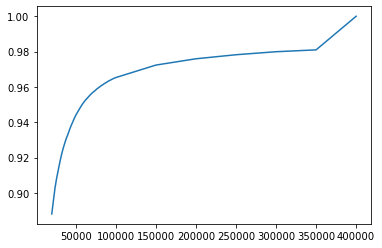

In [216]:
import pandas as pd
percent_of_all_weight = []
s = cooc.sum()
m = cooc.tocsc()
for i in range(0, 400000, 2000):
    p = m[:i,:i].sum() / s
    percent_of_all_weight.append(p)
del m
pd.Series(percent_of_all_weight, index=list(range(0, 100000, 2000))+list(range(100000, 450000, 50000))).iloc[10:].plot()

## Train with Python GloVe
 - this doesn't do fine-tuning, but that's fine for now

In [28]:
for i in range(2000, 400000, 2000):
    print(i, model_dict[i])

2000 cox
4000 clothes
6000 unexpected
8000 favors
10000 persecution
12000 inspect
14000 duchy
16000 fairway
18000 freddy
20000 baths
22000 hectic
24000 long-distance
26000 bose
28000 steeply
30000 mortally
32000 juninho
34000 elsie
36000 707
38000 unwind
40000 1667
42000 kirwan
44000 banu
46000 renton
48000 utilise
50000 bec
52000 overpopulation
54000 adhesives
56000 masato
58000 bolero
60000 baek
62000 scuppered
64000 47-yard
66000 towners
68000 metros
70000 b/w
72000 akiba
74000 boonyaratkalin
76000 jeev
78000 atiya
80000 klinghoffer
82000 hepworth
84000 lovie
86000 highrise
88000 43d
90000 azarov
92000 liberté
94000 75.2
96000 rawdon
98000 bushell
100000 capron
102000 940,000
104000 laan
106000 biwa
108000 olisadebe
110000 perpetua
112000 douthit
114000 11,900
116000 hermaphrodites
118000 antonucci
120000 biratnagar
122000 vrindavan
124000 canvey
126000 forêt
128000 manston
130000 12.74
132000 arsdale
134000 hauteur
136000 unambitious
138000 beckloff
140000 yaffa
142000 gimpel
14400

In [ ]:
n = 200000
#fpath = '/data/motes/coocs/enwiki_full.npz'
for fpath in ['/data/motes/coocs/all_weighted_10-12.npz']:
    just_name = os.path.splitext(os.path.split(fpath)[-1])[0]

    cooc = sparse.load_npz(fpath)
    # Load Sparse Matrix
    print(cooc.data.max(), cooc.data.min(), cooc.data.sum())

    # Truncate just to top n words in vocab
    if n < 400000:
        m = cooc.tocsc()[:n, :n].tocoo()
    else:
        m = cooc.tocoo()

    glove = Glove(no_components=300, learning_rate=0.05) 
    glove.fit(m, epochs=100, no_threads=25, verbose=True)
    del m
    dictionary = dict(list(model_dict.token2id.items())[:n])
    glove.add_dictionary(dictionary)

    # Convert to keyed vectors and save
    kv = modeling.glove_to_keyedvectors(glove)
    kv.save('/data/motes/models/{}_{}k.kv'.format(just_name, int(n/1000)))

264810141.26174298 0.05 40997530242.7755
Performing 100 training epochs with 25 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16


In [463]:
n = 100000
word_sums = pd.Series(np.array(full_mat.sum(1))[:n, 0], index=glove.dictionary.keys())

# only preserve vocab where there have been enough words seen
with open('/data/motes/all_weighted_1_model_include_vocab.txt', mode='w') as f:
    f.write('\n'.join(word_sums[word_sums > 500].index.tolist()))

10650